In [57]:
# Imports

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.distributions as dist

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Set device to GPU if available

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


Dataset

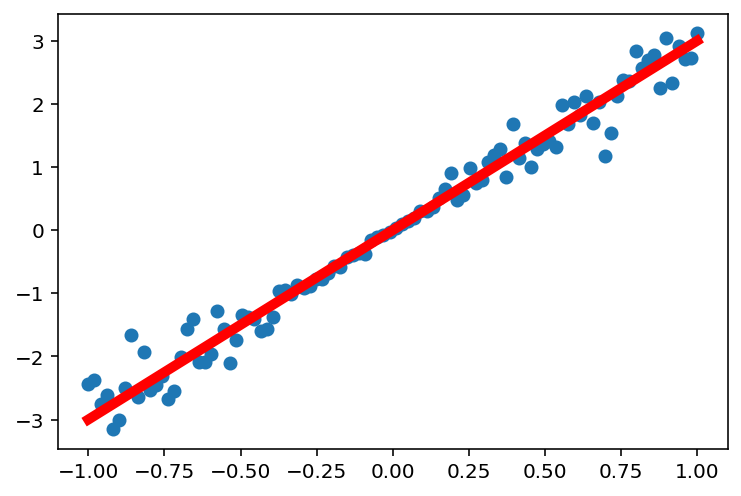

In [58]:
### Heteroskedastic Noise Dataset
                       
# Fix random seed
torch.manual_seed(0)

x = torch.linspace(-1, 1, 100)
f = lambda x: 3 * x

eps = torch.randn(x.size()) * x * 0.5
y = f(x) + eps

plt.scatter(x.numpy(), y.numpy())
plt.plot(x.numpy(), 3 * x.numpy(), 'r-', lw=5)

# Move data to device
x = x.to(device)
y = y.to(device)


In [59]:
class HeteroskedasticMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(HeteroskedasticMLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, 2)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        z = self.fc3(x)
        # Get mu and log_sigma from the last layer
        mu, log_sigma = z[:, 0], z[:, 1]
        return mu, log_sigma

In [60]:
# Create model

model = HeteroskedasticMLP(1, 100)

# Move model to device

model = model.to(device)

# Define loss function

def heteroskedastic_loss(y, mu, log_sigma):
    sigma = torch.exp(log_sigma)
    ll = dist.Normal(mu, sigma).log_prob(y)
    return -ll.mean()

In [61]:
with torch.no_grad():
    mu, log_sigma = model(x.unsqueeze(1))
    loss = heteroskedastic_loss(y, mu, log_sigma)
    print(loss)

tensor(2.9041, device='cuda:0')


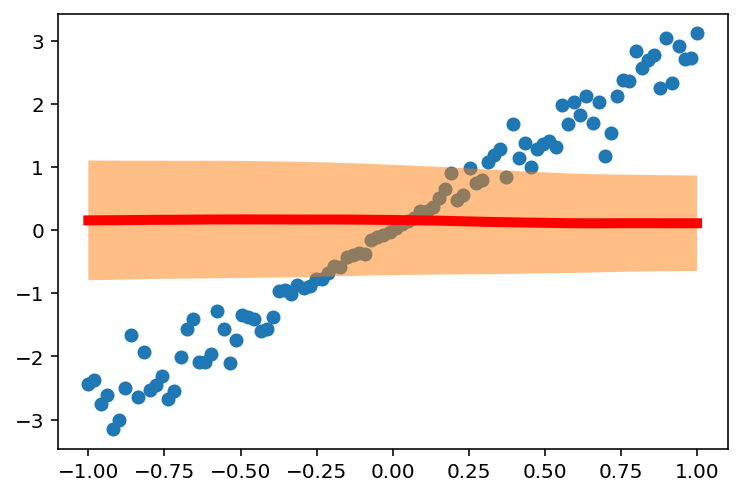

In [62]:
# Plot initial predictions

with torch.no_grad():
    mu, log_sigma = model(x.unsqueeze(1))
    sigma = torch.exp(log_sigma)
    plt.scatter(x.cpu().numpy(), y.cpu().numpy())
    plt.plot(x.cpu().numpy(), mu.cpu().numpy(), 'r-', lw=5)
    plt.fill_between(x.cpu().numpy(), mu.cpu().numpy() - sigma.cpu().numpy(), mu.cpu().numpy() + sigma.cpu().numpy(), alpha=0.5)

In [63]:
# Train model with Adam

optimizer = optim.Adam(model.parameters(), lr=0.01)
every_i = 10
outs= {}

for epoch in range(1000):
    # Store model predictions every_i epochs
    if epoch % every_i == 0:
        
        with torch.no_grad():
            mu, log_sigma = model(x.unsqueeze(1))
            outs[epoch] = {"mu":mu.cpu().numpy(),
                            "log_sigma":log_sigma.cpu().numpy()}

            # Print loss
            loss = heteroskedastic_loss(y, mu, log_sigma)
            print("Epoch: {}, Loss: {}".format(epoch, loss.item()))

    # Forward pass
    mu, log_sigma = model(x.unsqueeze(1))
    loss = heteroskedastic_loss(y, mu, log_sigma)

    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()



Epoch: 0, Loss: 2.904067277908325
Epoch: 10, Loss: 0.8787063956260681
Epoch: 20, Loss: 0.21688087284564972
Epoch: 30, Loss: 0.13268794119358063
Epoch: 40, Loss: 0.026131045073270798
Epoch: 50, Loss: -0.04720224440097809
Epoch: 60, Loss: -0.10559850186109543
Epoch: 70, Loss: -0.14626550674438477
Epoch: 80, Loss: -0.18292102217674255
Epoch: 90, Loss: -0.1582060158252716
Epoch: 100, Loss: -0.20254844427108765
Epoch: 110, Loss: -0.21556152403354645
Epoch: 120, Loss: -0.21742510795593262
Epoch: 130, Loss: -0.2227230668067932
Epoch: 140, Loss: -0.22566699981689453
Epoch: 150, Loss: -0.23224511742591858
Epoch: 160, Loss: -0.27615076303482056
Epoch: 170, Loss: -0.239326611161232
Epoch: 180, Loss: -0.2770726978778839
Epoch: 190, Loss: -0.3069627285003662
Epoch: 200, Loss: -0.2779914140701294
Epoch: 210, Loss: -0.27238503098487854
Epoch: 220, Loss: -0.3456583023071289
Epoch: 230, Loss: -0.2058892548084259
Epoch: 240, Loss: -0.2964232563972473
Epoch: 250, Loss: -0.306146502494812
Epoch: 260, Loss

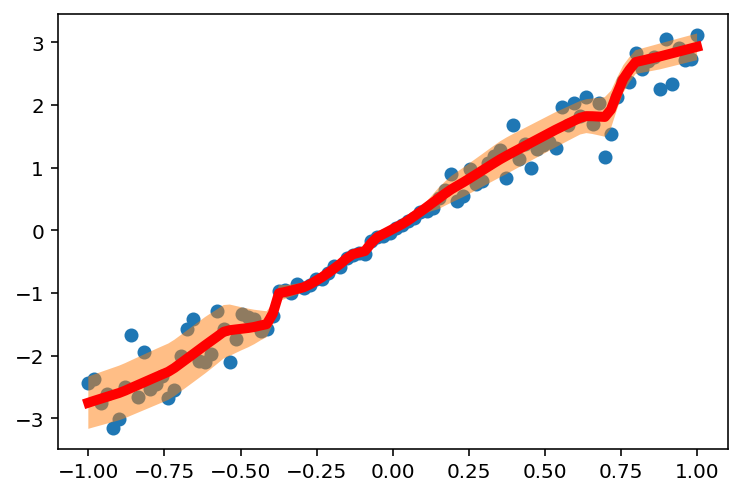

In [64]:
# Plot final predictions

with torch.no_grad():
    mu, log_sigma = model(x.unsqueeze(1))
    sigma = torch.exp(log_sigma)
    plt.scatter(x.cpu().numpy(), y.cpu().numpy())
    plt.plot(x.cpu().numpy(), mu.cpu().numpy(), 'r-', lw=5)
    plt.fill_between(x.cpu().numpy(), mu.cpu().numpy() - sigma.cpu().numpy(), mu.cpu().numpy() + sigma.cpu().numpy(), alpha=0.5)

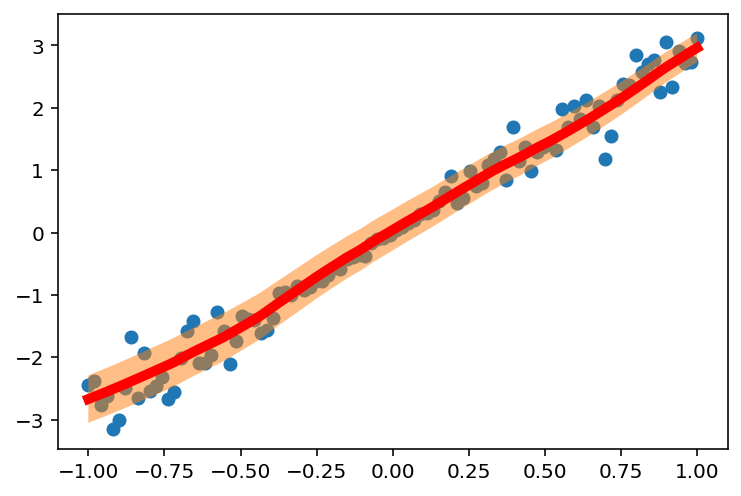

In [76]:
# Save predictions and use ffmpeg to create a video

import imageio
import os
import numpy as np

# Filter out warnings
import warnings
warnings.filterwarnings("ignore")

images = []
for i in range(0, 40, every_i):
    plt.clf()
    plt.scatter(x.cpu().numpy(), y.cpu().numpy())
    plt.plot(x.cpu().numpy(), outs[i]["mu"], 'r-', lw=5)
    plt.fill_between(x.cpu().numpy(), outs[i]["mu"] - np.exp(outs[i]["log_sigma"]), 
            outs[i]["mu"] + np.exp(outs[i]["log_sigma"]), alpha=0.5)
    plt.savefig("tmp.png")
    images.append(imageio.imread("tmp.png"))
    os.remove("tmp.png")

imageio.mimsave('heteroskedastic.gif', images, duration=0.1)

In [77]:
 # Plot gif
from IPython.display import Image
Image(url='heteroskedastic.gif')